# Data preparation

We combine the data, convert the labels for classification and apply augmentation

In [1]:
import os, sys, math, json
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

np.random.seed(0)

IMAGE_SIZE = [32, 32]

Tensorflow version 2.6.0


In [2]:
df = pd.read_json('../data/labelled_data/prepared-samples-binary.json')

y = df['label'].to_numpy()
X = np.array(df['data'].to_list())
X = np.expand_dims(X, axis=3)
print(y.shape)
print(X.shape)

(200,)
(200, 32, 32, 1)


In [3]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [4]:
# Squeezenet Model

bnmomemtum=0.9

def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(64)(y)
y = tf.keras.layers.Dense(32)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(2, activation='softmax')(y)

model = tf.keras.Model(x, y)

model.compile(
optimizer='adam',
loss= 'sparse_categorical_crossentropy',
metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66    

2021-11-23 09:27:45.655581: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-23 09:27:45.656394: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


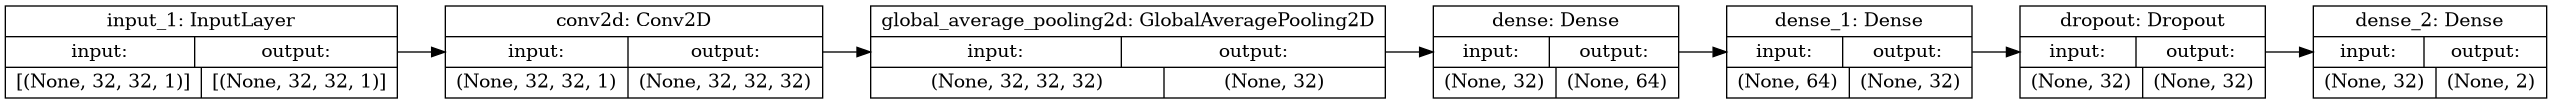

In [5]:
# Plot the model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

2021-11-23 09:27:45.838838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
10/10 [==============================] - 1s 39ms/step - loss: 1.2867 - accuracy: 0.5125 - val_loss: 0.6164 - val_accuracy: 0.7000
Epoch 2/50
10/10 [==============================] - 0s 32ms/step - loss: 1.0773 - accuracy: 0.5250 - val_loss: 0.7996 - val_accuracy: 0.7000
Epoch 3/50
10/10 [==============================] - 0s 26ms/step - loss: 0.9199 - accuracy: 0.5063 - val_loss: 0.7096 - val_accuracy: 0.3000
Epoch 4/50
10/10 [==============================] - 0s 17ms/step - loss: 0.7290 - accuracy: 0.5688 - val_loss: 0.6169 - val_accuracy: 0.7000
Epoch 5/50
10/10 [==============================] - 0s 33ms/step - loss: 0.7461 - accuracy: 0.5813 - val_loss: 0.6323 - val_accuracy: 0.7000
Epoch 6/50
10/10 [==============================] - 0s 33ms/step - loss: 0.7336 - accuracy: 0.5188 - val_loss: 0.6128 - val_accuracy: 0.7000
Epoch 7/50
10/10 [==============================] - 0s 42ms/step - loss: 0.7382 - accuracy: 0.5625 - val_loss: 0.6287 - val_accuracy: 0.7000
Epoch 8/50
10

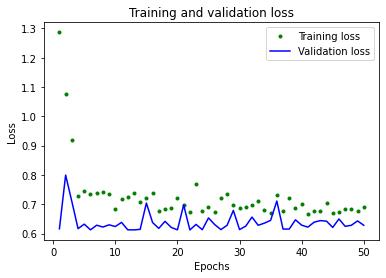

Test loss: 0.6274038553237915 / Test accuracy: 0.699999988079071


In [6]:
# Fit the model
EPOCHS = 50
BATCH_SIZE = 16
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("squeezenet-eval.png")
plt.show()

# Generate generalization metrics
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [7]:
# make and show single prediciton
%matplotlib inline

n=4 # pics per row

label = {1: 'Human',
         0: 'No Human'}

pred = model.predict(X_test)

classes = np.argmax(pred, axis = 1)

print(pred, classes)

[[0.61246085 0.38753918]
 [0.61539876 0.3846012 ]
 [0.6130551  0.38694495]
 [0.6126455  0.38735455]
 [0.6121253  0.38787472]
 [0.6130542  0.38694575]
 [0.6181479  0.38185212]
 [0.6131314  0.38686863]
 [0.61439735 0.3856026 ]
 [0.61261183 0.38738814]
 [0.61447495 0.38552502]
 [0.612997   0.38700292]
 [0.6140485  0.3859516 ]
 [0.6124993  0.38750073]
 [0.6125423  0.38745773]
 [0.61358744 0.3864126 ]
 [0.61454993 0.38545004]
 [0.6143437  0.38565627]
 [0.61539876 0.3846012 ]
 [0.6138716  0.38612837]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


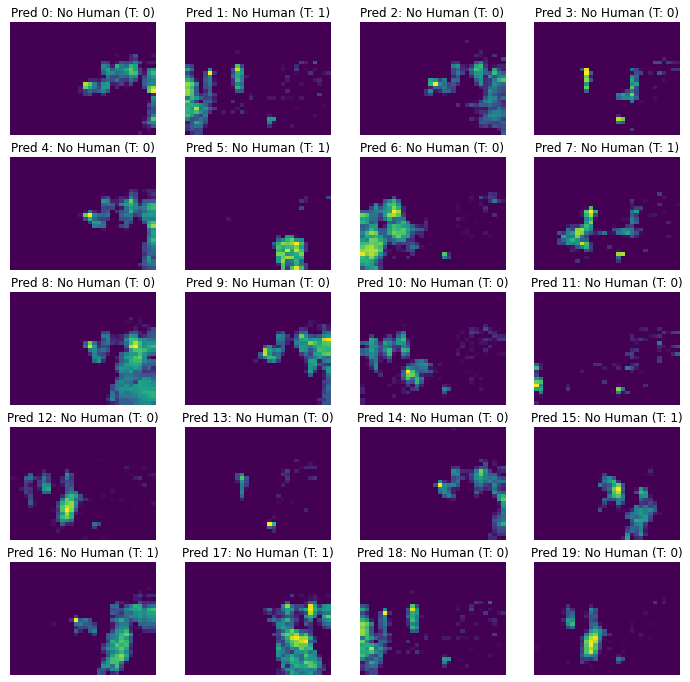

In [8]:
# Print predictions
fig, axes = plt.subplots(nrows=int(len(X_test)/n), ncols=n, figsize=(n*3, n*3), num='Predictions')
for ax, idx in zip(axes.reshape(-1), range(len(X_test))): 
    ax.set_axis_off()
    ax.set_title('Pred %i: %s (T: %i)' % (idx, label[classes[idx]], y_test[idx]))
    ax.imshow(X_test[idx].reshape(32, 32), interpolation='nearest', aspect='auto')